In [1]:
#import keras essentials and stuff
import tensorflow as tf
import matplotlib.pyplot as plt


2022-01-24 15:08:52.519857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-24 15:08:52.519868: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Making a neural net
---
the neural net takes two input variables for now 
the genre(as one bit encoded) and a historical event (i.e second world war, vietnam war, etc).

genres are labeled as follow:

- 1	&nbsp;&nbsp;  Musical
- 2	&nbsp;&nbsp; War
- 3	&nbsp;&nbsp; Romance
- 4	&nbsp;&nbsp; Family
- 5	&nbsp;&nbsp; Comedy
- 6	&nbsp;&nbsp; Animation
- 7	&nbsp;&nbsp; Western
- 8	&nbsp;&nbsp; Sci-Fi
- 9	&nbsp;&nbsp; Short
- 10&nbsp;&nbsp; 	Action
- 11&nbsp;&nbsp; 	Biography
- 12&nbsp;&nbsp; 	History
- 13&nbsp;&nbsp; 	Crime
- 14&nbsp;&nbsp; 	Music
- 15&nbsp;&nbsp; 	Fantasy
- 16&nbsp;&nbsp; 	Horror
- 17&nbsp;&nbsp; 	Drama
- 18&nbsp;&nbsp; 	Thriller
- 19&nbsp;&nbsp; 	Adventure
- 20&nbsp;&nbsp; 	Documentary
- 21&nbsp;&nbsp; 	Mystery

and historical events are labeled as:
- second world war  = 1
- vietnam war       = 2

this spits out a release year based on genre

# Preprocessing
---
preprocessing the data is necessary to make it suitable for the neural network

In [2]:
# import neccessary stuff 
#run this from the datascience-films folder
import pandas as pd 
import numpy as np
from pathlib import Path
import openpyxl

RESOURCE_PATH = Path('../cleaned_data')

df= pd.read_csv(RESOURCE_PATH / 'historical_all_genres.csv',sep=',')

df.head()

,primaryTitle,movie_release_year,event_year,EVENTID,genres,SUMMARY,plot,numVotes,averageRating,COUNTRY,CITY,historical_event
0,Infrarouge,2007.0,2007-01-22,31-24,Short,Soldiers opened fire on protesters inConakry o...,The Auschwitz Album is the only surviving vis...,9.0,7.1,Guinea,Conakry,Second World War
1,Infrarouge,2007.0,2006-09-19,17-70,Short,Army commanderGen. SonthiBoonyaratglin and fiv...,The Auschwitz Album is the only surviving vis...,9.0,7.1,Thailand,Bangkok,Second World War
2,Infrarouge,2007.0,2007-02-13,31-29,Short,The army moved quickly to re-establish order o...,The Auschwitz Album is the only surviving vis...,9.0,7.1,Guinea,Conakry,Second World War
3,Infrarouge,2007.0,2006-09-30,17-71,Short,"By the end of the month, in defiance of a mili...",The Auschwitz Album is the only surviving vis...,9.0,7.1,Thailand,Bangkok,Second World War
4,No Man Left Behind,2011.0,2011-05-30,64-176,"Action,Drama,Short",At least two AU soldiers were killed in Mogadi...,The Real Black Hawk Down tells the extraordin...,NaN,NaN,Somalia,Mogadishu,Vietnam War


In [3]:
df['numVotes'] = df['numVotes'].fillna(0)
#lastly pop our target we want
# df['target'] = list(zip(df.movie_release_year, df.averageRating))
target = df[['movie_release_year','averageRating','numVotes']]
target.averageRating =  target.averageRating.fillna(1)
target['numVotes'] = target['numVotes'].fillna(0)
target['numVotes'] = target['numVotes'].astype(np.int64)

target

/home/shivan/school/jaar_4/datascience-films/env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/tmp/ipykernel_28209/575288990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['numVotes'] = target['numVotes'].fillna(0)
/tmp/ipykernel_28209/575288990.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,movie_release_year,averageRating,numVotes
0,2007.0,7.1,9
1,2007.0,7.1,9
2,2007.0,7.1,9
3,2007.0,7.1,9
4,2011.0,1.0,0
...,...,...,...
3599,2011.0,1.0,0
3600,2011.0,1.0,0
3601,2011.0,1.0,0
3602,2011.0,1.0,0


In [4]:
# split genres per genre and create column per genre
unique_genres = pd.unique(df["genres"].str.split(",", expand=True).stack())
df = df.join(df.pop('genres').str.get_dummies(sep=',').astype(bool))
df

,primaryTitle,movie_release_year,event_year,EVENTID,SUMMARY,plot,numVotes,averageRating,COUNTRY,CITY,...,Reality-TV,Romance,Sci-Fi,Science Fiction,Short,Sport,TV Movie,Thriller,War,Western
0,Infrarouge,2007.0,2007-01-22,31-24,Soldiers opened fire on protesters inConakry o...,The Auschwitz Album is the only surviving vis...,9.0,7.1,Guinea,Conakry,...,False,False,False,False,True,False,False,False,False,False
1,Infrarouge,2007.0,2006-09-19,17-70,Army commanderGen. SonthiBoonyaratglin and fiv...,The Auschwitz Album is the only surviving vis...,9.0,7.1,Thailand,Bangkok,...,False,False,False,False,True,False,False,False,False,False
2,Infrarouge,2007.0,2007-02-13,31-29,The army moved quickly to re-establish order o...,The Auschwitz Album is the only surviving vis...,9.0,7.1,Guinea,Conakry,...,False,False,False,False,True,False,False,False,False,False
3,Infrarouge,2007.0,2006-09-30,17-71,"By the end of the month, in defiance of a mili...",The Auschwitz Album is the only surviving vis...,9.0,7.1,Thailand,Bangkok,...,False,False,False,False,True,False,False,False,False,False
4,No Man Left Behind,2011.0,2011-05-30,64-176,At least two AU soldiers were killed in Mogadi...,The Real Black Hawk Down tells the extraordin...,0.0,NaN,Somalia,Mogadishu,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,Full English,2011.0,2010-03-16,17-115,"An estimated 100,000 red-shirted protesters, u...",Edgar shows his true colors by running away a...,0.0,NaN,Thailand,Bangkok,...,False,False,False,False,True,False,False,False,False,False
3600,Full English,2011.0,2010-04-10,17-117,Thailand's political crisis deepened as the de...,Edgar shows his true colors by running away a...,0.0,NaN,Thailand,Bangkok,...,False,False,False,False,True,False,False,False,False,False
3601,Full English,2011.0,2010-04-22,17-119,Following the army assault on April 10 on the ...,Edgar shows his true colors by running away a...,0.0,NaN,Thailand,Bangkok,...,False,False,False,False,True,False,False,False,False,False
3602,Full English,2011.0,2010-05-14,17-122,"Violence erupted on the barricades on May 14, ...",Edgar shows his true colors by running away a...,0.0,NaN,Thailand,Bangkok,...,False,False,False,False,True,False,False,False,False,False


In [5]:
df = df.join(df.pop('historical_event').str.join('').str.get_dummies().astype(bool))
df

,primaryTitle,movie_release_year,event_year,EVENTID,SUMMARY,plot,numVotes,averageRating,COUNTRY,CITY,...,Sci-Fi,Science Fiction,Short,Sport,TV Movie,Thriller,War,Western,Second World War,Vietnam War
0,Infrarouge,2007.0,2007-01-22,31-24,Soldiers opened fire on protesters inConakry o...,The Auschwitz Album is the only surviving vis...,9.0,7.1,Guinea,Conakry,...,False,False,True,False,False,False,False,False,True,False
1,Infrarouge,2007.0,2006-09-19,17-70,Army commanderGen. SonthiBoonyaratglin and fiv...,The Auschwitz Album is the only surviving vis...,9.0,7.1,Thailand,Bangkok,...,False,False,True,False,False,False,False,False,True,False
2,Infrarouge,2007.0,2007-02-13,31-29,The army moved quickly to re-establish order o...,The Auschwitz Album is the only surviving vis...,9.0,7.1,Guinea,Conakry,...,False,False,True,False,False,False,False,False,True,False
3,Infrarouge,2007.0,2006-09-30,17-71,"By the end of the month, in defiance of a mili...",The Auschwitz Album is the only surviving vis...,9.0,7.1,Thailand,Bangkok,...,False,False,True,False,False,False,False,False,True,False
4,No Man Left Behind,2011.0,2011-05-30,64-176,At least two AU soldiers were killed in Mogadi...,The Real Black Hawk Down tells the extraordin...,0.0,NaN,Somalia,Mogadishu,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599,Full English,2011.0,2010-03-16,17-115,"An estimated 100,000 red-shirted protesters, u...",Edgar shows his true colors by running away a...,0.0,NaN,Thailand,Bangkok,...,False,False,True,False,False,False,False,False,False,False
3600,Full English,2011.0,2010-04-10,17-117,Thailand's political crisis deepened as the de...,Edgar shows his true colors by running away a...,0.0,NaN,Thailand,Bangkok,...,False,False,True,False,False,False,False,False,False,False
3601,Full English,2011.0,2010-04-22,17-119,Following the army assault on April 10 on the ...,Edgar shows his true colors by running away a...,0.0,NaN,Thailand,Bangkok,...,False,False,True,False,False,False,False,False,False,False
3602,Full English,2011.0,2010-05-14,17-122,"Violence erupted on the barricades on May 14, ...",Edgar shows his true colors by running away a...,0.0,NaN,Thailand,Bangkok,...,False,False,True,False,False,False,False,False,False,False


In [6]:
#get the events 

# get numeric features and set as target
numeric_feature_names = list(unique_genres)
numeric_feature_names.append('Vietnam War')
numeric_feature_names.append('Second World War')
numeric_features = df[numeric_feature_names]
numeric_features.head()





,Short,Action,Drama,Documentary,Crime,Thriller,Comedy,Romance,War,Adventure,...,Foreign,Sci-Fi,Biography,Adult,Reality-TV,News,Sport,TV Movie,Vietnam War,Second World War
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,True,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


# Simple linear regression model
---
this is a very simply linear regression model from sklearn to grasp the basics and just to try if it is suitable

In [7]:
#also convert
from sklearn.model_selection import train_test_split

# splits the training and test data set in 65% : 35%
# assign random_state to any value.This ensures consistency.
X_train, X_test, Y_train, Y_test = train_test_split(numeric_features, target, test_size = 0.30, random_state=20)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_test,Y_test,test_size=0.5)
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

print(X_valid.shape)
print(Y_valid.shape)


(2522, 31)
(2522, 3)
(541, 31)
(541, 3)
(541, 31)
(541, 3)


In [8]:
#import linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)

y_train_predict = linear_model.predict(X_train)

rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print(f'RMSE is {rmse}')
print(f'R2 score is {r2}')
print("\n")

y_test_predict = linear_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print(f'RMSE is {rmse}')
print(f'R2 score is {r2}')
print("This model is not suitable!")



The model performance for training set
--------------------------------------
RMSE is 13582.73109078084
R2 score is 0.29276658387719134


The model performance for testing set
--------------------------------------
RMSE is 17371.65748536443
R2 score is 0.2658096526544515
This model is not suitable!


# Neural net
---
this part is for initializing the neural net

In [9]:
# convert to the features to a tensor

X_train = tf.convert_to_tensor(X_train, dtype=tf.int64)
Y_train = tf.convert_to_tensor(Y_train, dtype=tf.int64)
X_test = tf.convert_to_tensor(X_test, dtype=tf.int64)
Y_test = tf.convert_to_tensor(Y_test, dtype=tf.int64)
X_valid = tf.convert_to_tensor(X_valid, dtype=tf.int64)
Y_valid = tf.convert_to_tensor(Y_valid, dtype=tf.int64)



2022-01-24 15:08:55.983680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-24 15:08:55.984090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-24 15:08:55.984139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-24 15:08:55.984177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-24 15:08:55.984238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [16]:
class Neural_Net():

    def __init__(self):
        """
        Set up the neural net. 
        - input nodes: 
            - historical event label
            - genre 
            - number of expected reviews to get.
        - output node 
            - predicted release year
            - average predicted rating
        """
        self.normalizer = tf.keras.layers.Normalization(axis=1)
        self.normalizer.adapt(X_train)
        opt = tf.keras.optimizers.SGD(learning_rate=0.00000001,momentum=0.90)

        self.model = tf.keras.Sequential([
            self.normalizer, 
            tf.keras.layers.Dense(15,activation='relu'),
            tf.keras.layers.Dropout(rate=0.6),
            tf.keras.layers.Dense(12, activation='relu'),
            tf.keras.layers.Dropout(rate=0.6),
            tf.keras.layers.Dense(3),
        ])
        self.earlystopping = tf.keras.callbacks.EarlyStopping(
                                                        monitor ="loss", 
                                                        mode ="min", patience = 500, 
                                                        min_delta=5,
                                                        restore_best_weights = True
                                                        )
        self.model.compile(
            optimizer= opt,
            loss='mean_squared_error'
            , metrics= ['accuracy']
            )

    def train(self, epochs: int):
        self.history = self.model.fit(
            X_train,
            Y_train,
            epochs=epochs,
            batch_size=8,
            validation_data=(X_valid, Y_valid),
            verbose=0
            )

    def evaluate(self):
        self.normalizer.adapt(X_test)
        self.results = self.model.evaluate(X_test, Y_test, batch_size=25)
        print(f"results: {self.results}")

    
    def predict(self, input: tf.Tensor):
        self.normalizer.adapt(input)
        predictions = self.model.predict(input)
        for prediction in predictions:
            print(f"prediction: {prediction}")


    def convert_to_input(self, list_of_inputs: list):
        tmp_df = pd.DataFrame(columns=numeric_feature_names)
        for index,sample in enumerate(list_of_inputs):
            tmp_df = tmp_df.append(pd.Series(), ignore_index=True)
            for col_index, _ in enumerate(tmp_df.columns):
                for genre in sample[1]:
                    tmp_df.loc[index, tmp_df.columns.values == genre] = True
        tmp_df = tmp_df.fillna(False)
        print(tmp_df.head(5))
        return tf.convert_to_tensor(tmp_df, dtype=tf.int64)




    def save(self):
        """
        save the trained weights.
        """
        self.model.save_weights('checkpoints/Model_vietnam_save_genres')
    
    def load(self, path: str):
        """
        load the weights of the model
        """
        self.model.load_weights(path)

    def plot_cost(self):
        # acc = self.history.history['acc']
        # val_acc = self.history.history['val_acc']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs = range(1, len(loss) + 1)

        plt.plot(epochs, loss, 'bo', label='Training_loss')
        plt.plot(epochs,val_loss, 'bo', color='g', label='Val_loss')
        # plt.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()

model = Neural_Net()

In [11]:
#train the model
model.train(200)

In [13]:
# evaluate the model
model.evaluate()


22/22 [==============================] - 0s 574us/step - loss: 329029792.0000 - accuracy: 0.1201
results: [329029792.0, 0.12014787644147873]


In [ ]:
#save the model:
model.save()

In [ ]:
#load the model
model.load('checkpoints/Model_save_genres')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for checkpoints/Model_save_genres

In [17]:
#predict using the model
use_samples = [
    [['War',"Documentary"],["Vietnam War"]],
    [["War"], ["Second World War"]],
    [["Documentary"]],
    [["Action"]],
    [["War"]],
    ["Sport"]
    ]
new_data = model.convert_to_input(use_samples)
model.predict(new_data)

Empty DataFrame
Columns: [Short, Action, Drama, Documentary, Crime, Thriller, Comedy, Romance, War, Adventure, Musical, (no genres listed), History, Horror, Music, Animation, Mystery, Family, Science Fiction, Fantasy, Western, Foreign, Sci-Fi, Biography, Adult, Reality-TV, News, Sport, TV Movie, Vietnam War, Second World War]
Index: []

[0 rows x 31 columns]


/tmp/ipykernel_28209/166247199.py:65: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp_df = tmp_df.append(pd.Series(), ignore_index=True)


IndexError: list index out of range

/tmp/ipykernel_1564/62798034.py:100: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs,val_loss, 'bo', color='g', label='Val_loss')


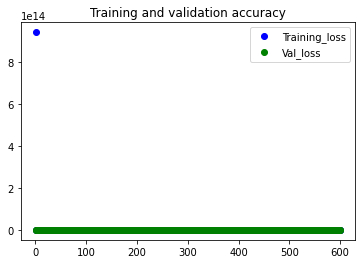

In [ ]:
model.plot_cost()

# Next steps
---

whoop